In [128]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import  _tconfint_generic
from matplotlib import pyplot as plt

from scipy.stats import chi2_contingency


In [129]:
data = pd.read_csv("credit_card_default_analysis.csv")

In [130]:
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# Задание 1

Гипотезу о равенстве медиан будем проверять с помощью персентилей и пересечения доверетильных интервалов (Как мы это делали в первой недели) 
Также визуализируем доверительные интервалы

In [131]:
X_1 = data["LIMIT_BAL"].values[data["default"] == 0]
X_2 = data["LIMIT_BAL"].values[data["default"] == 1]

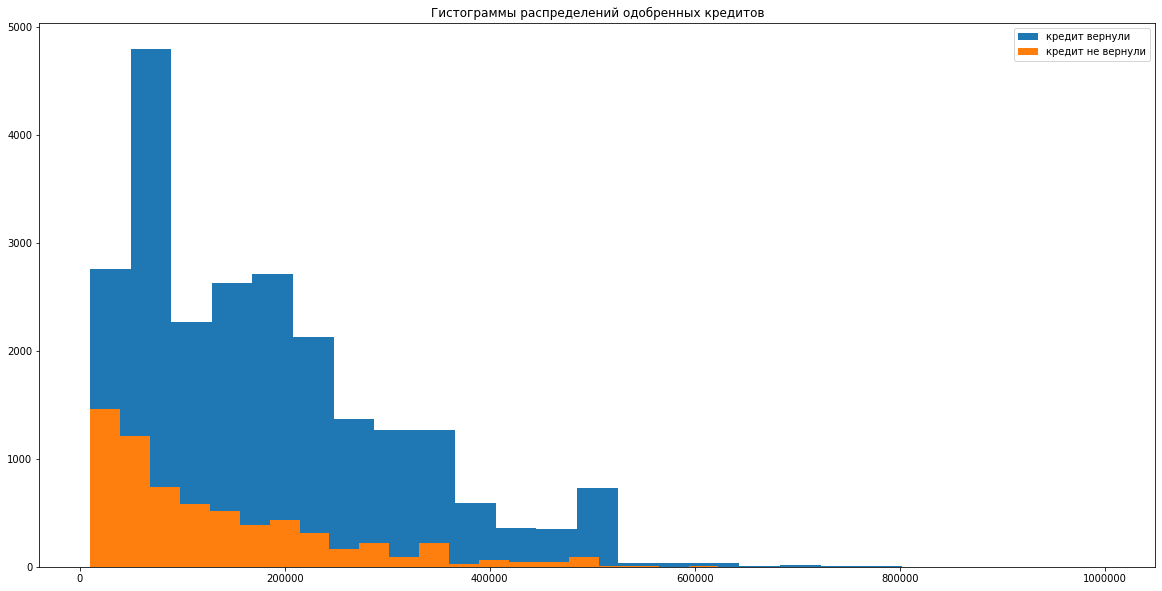

In [132]:
plt.figure(figsize = (20, 10))
plt.title("Гистограммы распределений одобренных кредитов")
plt.hist(X_1, bins = 25, label = "кредит вернули")
plt.hist(X_2, bins = 25, label = "кредит не вернули")
plt.legend()
plt.show()

In [133]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [134]:
sample1 = np.median(get_bootstrap_samples(X_1, 1000), axis = 1)
sample2 = np.median(get_bootstrap_samples(X_2, 1000), axis = 1)

In [135]:
X_1per = stat_intervals(sample1, 0.05)

In [136]:
X_2per = stat_intervals(sample2, 0.05)

In [137]:
X_2per

array([80000., 90000.])

In [138]:
X_1per

array([150000., 150000.])

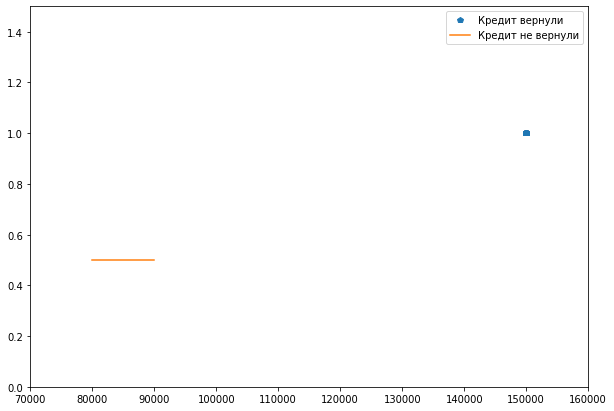

In [143]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(X_1per[0], X_1per[1], 100), np.ones(100),"p", label = "Кредит вернули")
plt.plot(np.linspace(X_2per[0], X_2per[1], 100), np.ones(100)/2, label = "Кредит не вернули")
plt.xlim(left = 70000, right = 160000)
plt.ylim(bottom = 0, top = 1.5)
plt.legend()
plt.show()

Как мы видим из персентилей доверительные интервалы не пересекаются

Давайте построим доверительный интервал с помощью распределения стьюдента для средних

In [10]:
X_1t = _tconfint_generic(X_1.mean(), X_1.std(ddof = 1)/np.sqrt(len(X_1)),
                    len(X_1) - 1,
                       0.05, 'two-sided')
X_2t = _tconfint_generic(X_2.mean(), X_2.std(ddof = 1)/np.sqrt(len(X_2)),
                    len(X_2) - 1,
                       0.05, 'two-sided')

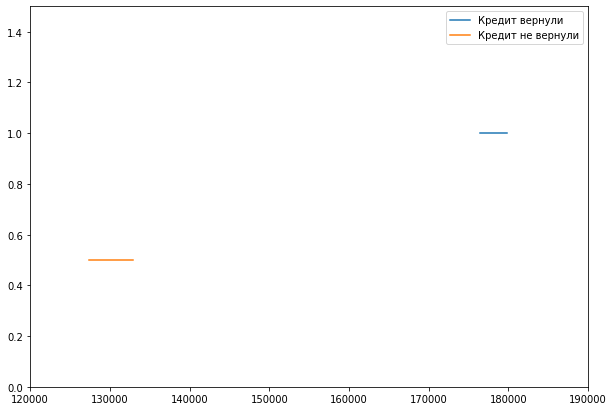

In [11]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(X_1t[0], X_1t[1], 100), np.ones(100), label = "Кредит вернули")
plt.plot(np.linspace(X_2t[0], X_2t[1], 100), np.ones(100)/2, label = "Кредит не вернули")
plt.xlim(left = 120000, right = 190000)
plt.ylim(bottom = 0, top = 1.5)
plt.legend()
plt.show()

Как мы видим на доверительных интервалах разница очевидна

Гипотезу о равенстве распределений будем проводить с помощью критерия Манна-Уитни, потому что выборки независимые.

Выборки: $X_1 = \{ X_{11}, ..., X_{1n_1}\}$ - LIMIT_BAL среди вернувших кредит

$X_2 = \{ X_{21}, ..., X_{2n_1}\}$ -  LIMIT_BAL среди невернувших кредит.

Нулевая гипотеза $H_0$ : $F_{X_1}(x) = F_{X_2}(x)$ 

Альтернатива $H_1$ : $F_{X_1}(x) != F_{X_2}(x+\Delta)$

Статистика $R(X_1, X_2) = \sum^{n_1}_{i = 1} rank(X_{1i})$

Нулевое распределение табличное

In [12]:
stats.mannwhitneyu(X_1, X_2)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Следовательно на уровне доверия 0.05 мы можем с большой уверенностью отвергнуть нулевую гипотезу ($p_{val} = 6.1\cdot 10^{-190}$).

In [13]:
X_1.mean() - X_2.mean()

47990.069654772495

In [14]:
(X_1.mean() - X_2.mean())/X_1.mean()

0.2694561676908547

С практической точки зрения, как мы видим, разница в средних достаточно велика(50 тыс), что составляет 27% от абсолютного значения 

# Задание 2

В этой части задания нам нужно оценить разницу в долях, следовательно нам нужны критерии для долей в независимых выборках.

Но для начала посмотрим на данные

In [15]:
X_1 = data["SEX"].values[data["default"] == 0]
X_2 = data["SEX"].values[data["default"] == 1]

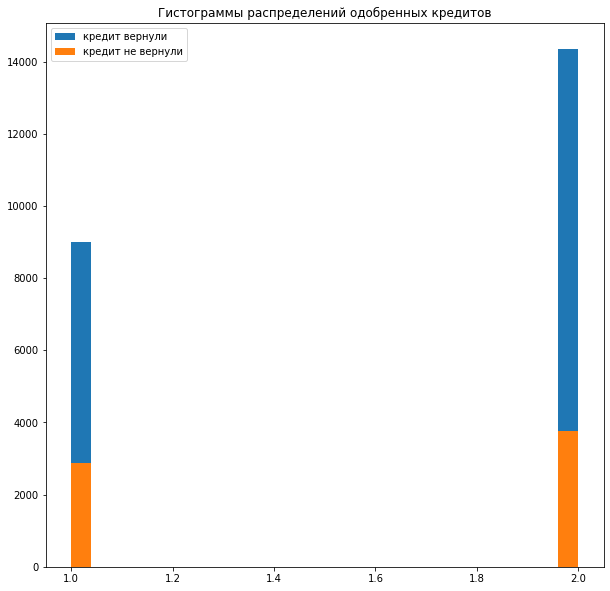

In [16]:
plt.figure(figsize = (10, 10))
plt.title("Гистограммы распределений одобренных кредитов")
plt.hist(X_1, bins = 25, label = "кредит вернули")
plt.hist(X_2, bins = 25, label = "кредит не вернули")
plt.legend()
plt.show()

Для начала построим доверительные интервали для доли мужского пола в каждой выборке

In [17]:
def my_proportion_confint(count, nobs, alpha=0.05):
    q_ = count * 1. / nobs
    alpha_2 = 0.5 * alpha
    std_ = np.sqrt(q_ * (1 - q_) / nobs)
    dist = stats.norm.isf(alpha / 2.) * std_
    ci_low = q_ - dist
    ci_upp = q_ + dist
    return ci_low, ci_upp

In [18]:
p1_int = my_proportion_confint(X_1[X_1 == 1].shape[0], X_1.shape[0])
p2_int = my_proportion_confint(X_2[X_2 == 2].shape[0], X_2.shape[0])

In [19]:
p1_int

(0.37960806572767264, 0.3920919856333957)

In [20]:
p2_int

(0.5551371736238107, 0.5789797642905956)

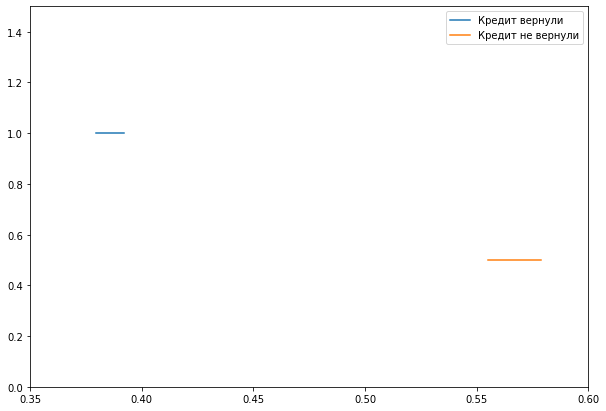

In [21]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(p1_int[0], p1_int[1], 100), np.ones(100), label = "Кредит вернули")
plt.plot(np.linspace(p2_int[0], p2_int[1], 100), np.ones(100)/2, label = "Кредит не вернули")
plt.xlim(left = 0.35, right = 0.6)
plt.ylim(bottom = 0, top = 1.5)
plt.legend()
plt.show()

Как мы видим доли не одинаковые, среди не вернувших кредит поровну и мужчин и женщин, а среди вернувших кредит больше жинщин.

Давайте теперь посчитаем статистическую значимость 

Воспользуемся z - критерием для долей



Выборки: $X_1 = \{ X_{11}, ..., X_{1n_1}\}$ - SEX среди вернувших кредит

$X_2 = \{ X_{21}, ..., X_{2n_1}\}$ -  SEX среди невернувших кредит.

Нулевая гипотеза $H_0$ : $p_1 = p_2$ 

Альтернатива $H_1$ : $p_1 != p_2$

Статистика $Z(X_1, X_2) = \frac{p_1 - p_2}{\sqrt{P(1-P)(\frac{1}{n_1}+\frac{1}{n_2})}}$

Нулевое распределение: $Z(X_1, X_2) =N(0, 1)$

In [22]:
def count_s(p1, n1, p2, n2):
    P = (p1*n1+p2*n2)/(n1+n2)
    return np.sqrt(P*(1-P)*(1/n1+1/n2))

def count_p(p1, n1, p2, n2):
    S = count_s(p1, n1, p2, n2)
    t = (p1 - p2)/S
    return 2*(1-stats.norm.cdf(abs(t)))

In [23]:
p1 = X_1[X_1 == 1].shape[0] / X_1.shape[0]
n1 = X_1.shape[0]
p2 = X_2[X_2 == 2].shape[0] / X_2.shape[0]
n2 = X_2.shape[0]
print(count_p(p1, n1, p2, n2))

0.0


Получилось $p_{val} = 0$. Как я понял это связано с тем, что $p_{val}$ меньше машинной точности))

Построим доверительный интервал для разности

In [35]:
def proportions_diff_confint_ind(p1, n1, p2, n2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)

    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)

In [36]:
proportions_diff_confint_ind(p1, n1, p2, n2)

(-0.194665015889303, -0.16775187066403494)

И доверительный интервал еще раз нас убеждает в том, что доли разные.

# Часть 3 

In [41]:
table = data[["EDUCATION", "default"]].groupby(["EDUCATION", "default"]).size().unstack(fill_value=0)

table_norma = table.copy()

count = table_norma.sum(axis=1)
table_norma['count'] = count
table_norma = table_norma.iloc[:, :-1].div(count, axis=0)

table_norma['count'] = count

table_norma

default,0,1,count
EDUCATION,,,
0,1.000000,0.000000,14
1,0.807652,0.192348,10585
2,0.762651,0.237349,14030
3,0.748424,0.251576,4917
4,0.943089,0.056911,123
5,0.935714,0.064286,280
6,0.843137,0.156863,51


Рассмотрим критерий Хи - квадрат для проверки гипотезы о том, что есть зависимость между этими двумя признаками 

In [46]:
chi2_contingency(table.values)

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

То есть мы уверенно ($p_{val} = 1.2 \cdot10^{-32}$) отклонить нулевую гипотезу в ползу существования зависимости


Давайте тогда теперь построим доверительный интервал для доли

In [61]:
p_int = my_proportion_confint(table[0].values, count.values)

In [62]:
p_int

(array([1.        , 0.80014375, 0.75561141, 0.73629535, 0.90214749,
        0.90698678, 0.74332772]),
 array([1.        , 0.81516093, 0.76969151, 0.76055232, 0.98403137,
        0.96444179, 0.94294679]))

In [65]:
table_norma["left"] = p_int[0]
table_norma["right"] = p_int[1]

In [66]:
table_norma

default,0,1,count,left,right
EDUCATION,,,,,
0,1.000000,0.000000,14,1.000000,1.000000
1,0.807652,0.192348,10585,0.800144,0.815161
2,0.762651,0.237349,14030,0.755611,0.769692
3,0.748424,0.251576,4917,0.736295,0.760552
4,0.943089,0.056911,123,0.902147,0.984031
5,0.935714,0.064286,280,0.906987,0.964442
6,0.843137,0.156863,51,0.743328,0.942947


Вывод: Как мы видим люди с образованием Доктор (0), возвращают кредит с наибольшей вероятностью. Реже всего возвращают кредиты выпускники школ и бакалавры

# Часть 4

In [67]:
table = data[["MARRIAGE", "default"]].groupby(["MARRIAGE", "default"]).size().unstack(fill_value=0)

table_norma = table.copy()

count = table_norma.sum(axis=1)
table_norma['count'] = count
table_norma = table_norma.iloc[:, :-1].div(count, axis=0)

table_norma['count'] = count

table_norma

default,0,1,count
MARRIAGE,,,
0,0.907407,0.092593,54
1,0.765283,0.234717,13659
2,0.790717,0.209283,15964
3,0.739938,0.260062,323


Для оценки влияния посчитаем коэффициент V Крамера

In [68]:
chi2_contingency(table.values)

(35.66239583433609,
 8.825862457577375e-08,
 3,
 array([[4.20552000e+01, 1.19448000e+01],
        [1.06376292e+04, 3.02137080e+03],
        [1.24327632e+04, 3.53123680e+03],
        [2.51552400e+02, 7.14476000e+01]]))

In [69]:
np.sqrt(35.66239583433609/(2*table.values.sum()))

0.024379771613073028

Как мы видим семейное положение влияет на default

/Users/maxim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/maxim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


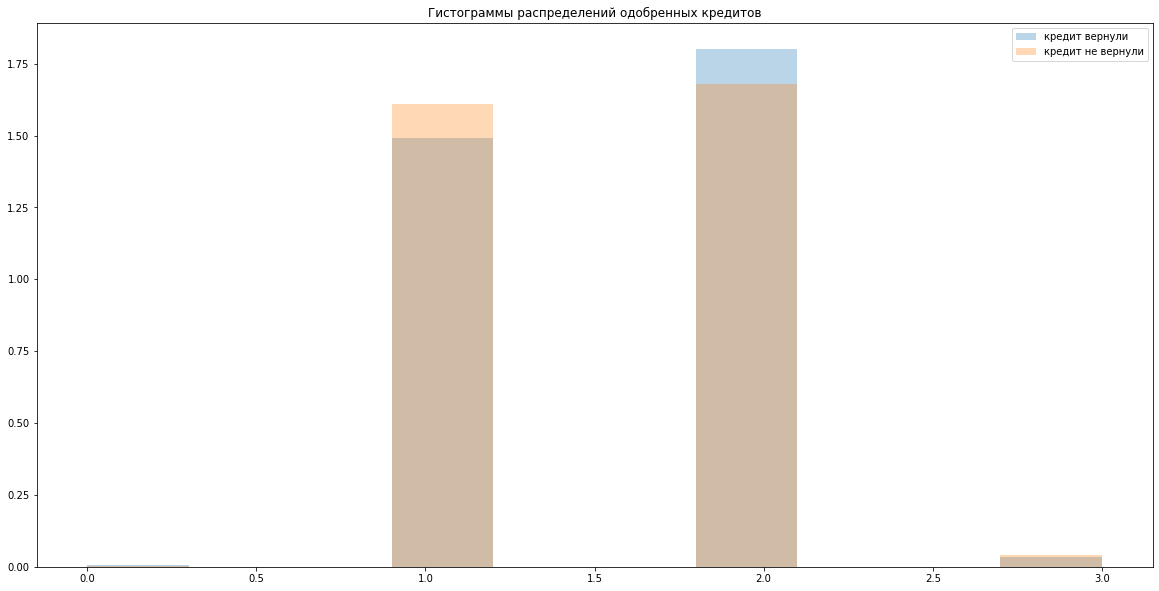

In [81]:

plt.figure(figsize = (20, 10))
plt.title("Гистограммы распределений одобренных кредитов")
plt.hist(data["MARRIAGE"][data["default"] == 0], normed = True, alpha = 0.3, label = "кредит вернули")
plt.hist(data["MARRIAGE"][data["default"] == 1], normed = True, alpha = 0.3, label = "кредит не вернули")
plt.legend()
plt.show()

# Часть 5

In [144]:
X_1 = data["AGE"].values[data["default"] == 0]
X_2 = data["AGE"].values[data["default"] == 1]

/Users/maxim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/maxim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


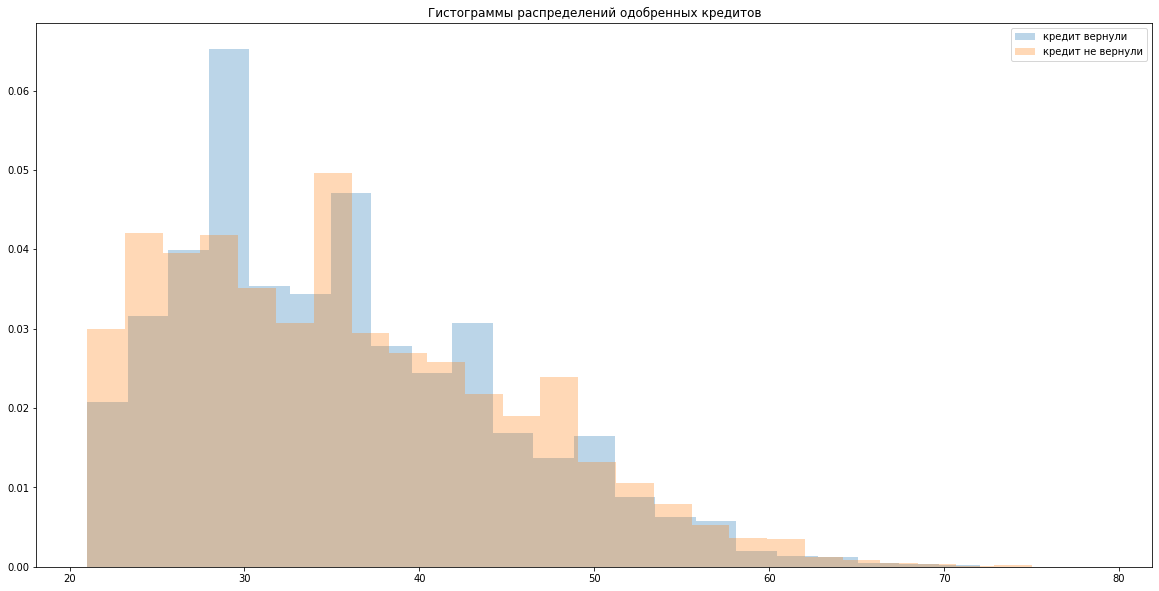

In [145]:
plt.figure(figsize = (20, 10))
plt.title("Гистограммы распределений одобренных кредитов")
plt.hist(X_1, bins = 25, label = "кредит вернули", normed = True, alpha = 0.3)
plt.hist(X_2, bins = 25, label = "кредит не вернули", normed = True, alpha = 0.3)
plt.legend()
plt.show()

In [146]:
sample1 = np.median(get_bootstrap_samples(X_1, 1000), axis = 1)
sample2 = np.median(get_bootstrap_samples(X_2, 1000), axis = 1)

In [147]:
X_1per = stat_intervals(sample1, 0.05)

In [148]:
X_2per = stat_intervals(sample2, 0.05)

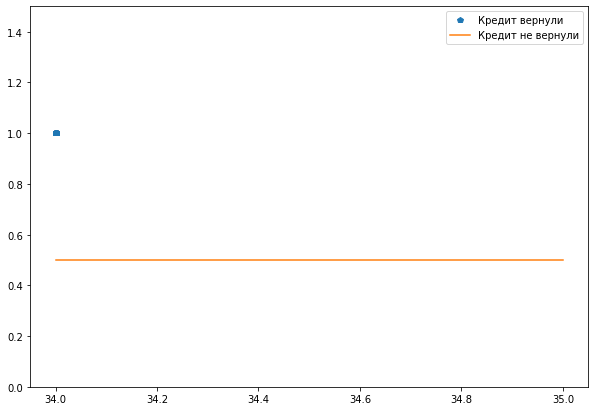

In [150]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(X_1per[0], X_1per[1], 100), np.ones(100),"p", label = "Кредит вернули")
plt.plot(np.linspace(X_2per[0], X_2per[1], 100), np.ones(100)/2, label = "Кредит не вернули")
plt.ylim(bottom = 0, top = 1.5)
plt.legend()
plt.show()

Как мы видим из персентилей нелзя ничего однозначного сказать

Давайте построим доверительный интервал с помощью распределения стьюдента для средних

In [94]:
X_1t = _tconfint_generic(X_1.mean(), X_1.std(ddof = 1)/np.sqrt(len(X_1)),
                    len(X_1) - 1,
                       0.05, 'two-sided')
X_2t = _tconfint_generic(X_2.mean(), X_2.std(ddof = 1)/np.sqrt(len(X_2)),
                    len(X_2) - 1,
                       0.05, 'two-sided')

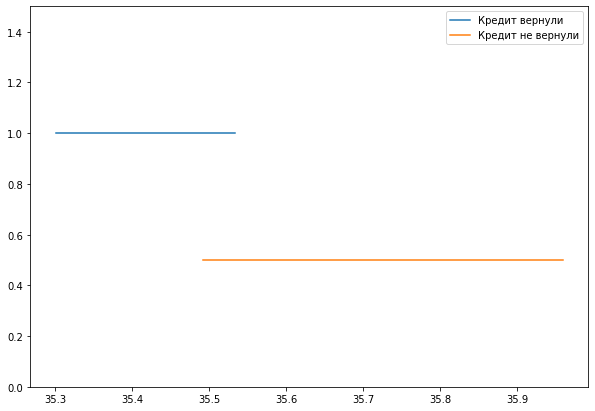

In [95]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(X_1t[0], X_1t[1], 100), np.ones(100), label = "Кредит вернули")
plt.plot(np.linspace(X_2t[0], X_2t[1], 100), np.ones(100)/2, label = "Кредит не вернули")

plt.ylim(bottom = 0, top = 1.5)
plt.legend()
plt.show()

Как мы видим на доверительных интервалах разница есть, но доверительные интервалы пересекаются

Гипотезу о равенстве распределений будем проводить с помощью критерия Манна-Уитни, потому что выборки независимые.

Выборки: $X_1 = \{ X_{11}, ..., X_{1n_1}\}$ - LIMIT_BAL среди вернувших кредит

$X_2 = \{ X_{21}, ..., X_{2n_1}\}$ -  LIMIT_BAL среди невернувших кредит.

Нулевая гипотеза $H_0$ : $F_{X_1}(x) = F_{X_2}(x)$ 

Альтернатива $H_1$ : $F_{X_1}(x) != F_{X_2}(x+\Delta)$

Статистика $R(X_1, X_2) = \sum^{n_1}_{i = 1} rank(X_{1i})$

Нулевое распределение табличное

In [96]:
stats.mannwhitneyu(X_1, X_2)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Следовательно на уровне доверия 0.05 мы не можем отвергнуть нулевую гипотезу ($p_{val} = 0.186$).

In [97]:
X_1.mean() - X_2.mean()

-0.308472517494188

In [98]:
(X_1.mean() - X_2.mean())/X_1.mean()

-0.008709664900360257

С практической точки зрения, как мы видим, разница в средних достаточно мала (4 месяца), И мы не можем отвергнуть гипотезу о равенстве распределений с критерием 0.05